In [1]:
# imports
import numpy as np
from numpy import loadtxt as loadtxt

import matplotlib.pyplot as plt

import torch
from tqdm import tqdm

from haloidp_analysis import minimize, profile_likelihood, plot_eta, convert_params_to_fit_to_halo_id

from haloidp_analysis import minimize_with_mass

In [2]:
# set device

device = "cuda"
type_torch = torch.double

In [3]:
# load in data

materials = ["Si", "Ge"]

observed_rates = []
for material in materials:

    fpath = f'./halo_independent/mock_data/ModelAnsh10MeV_{material}.csv'
    fake_data = loadtxt(fpath,delimiter=',') # shape: (10,2)
    rates = fake_data[:,1]
    observed_rates.append(torch.from_numpy(rates).to(device))



## What are we trying to learn?


`learnable_weights`: the object that PyTorch optimizes

### 1. A set of numbers $g_i$ that parameterize the halo velocity profile

This is usually referred to in the code as `halo_id_params`. Number of elements: `num_steps`.

We want to enforce that the steps are monotonically decreasing. So it might be easier to parameterize the *differences* between steps, and then enforce that all of these differences are stricly negative.

`halo_id_params = -np.cumsum(learnable_weights**2)` will be monotonically decreasing, no matter what `learnable_weights` is.


### 2. The best-fit mass of the DM particle

This will be a scalar. Actually, the true mass is going to be the last element squared, to enforce positivity.

In [4]:
def run_one_network(num_steps, num_epochs = 5000, lr = 0.1, alpha = .1):
    
    """
    num_steps: how many g_i to learn
    """

    # INITIALIZE WEIGHTS

    # randomly initialize the values for g_i
    learnable_weights = torch.rand(num_steps,dtype=type_torch,device=device)
    # pick a value for the mass
    learnable_mass = torch.tensor(np.sqrt(20),dtype=type_torch,device=device)

    """
    plt.figure()
    plt.plot(learnable_weights.cpu())
    plt.title("Learnable weights (pre-training)")
    plt.show()

    plt.figure()
    plt.plot(convert_params_to_fit_to_halo_id(learnable_weights).cpu())
    plt.title("Monotonically-decreasing eta function (pre-training)")
    plt.show()
    """

    for FDMn in [0]:

        params_, losses_, masses_ =  minimize_with_mass(FDMn, observed_rates, materials, profile_likelihood, learnable_weights, learnable_mass, epochs=num_epochs,
                                                     lr=lr, device=device, optimizer_algorithm='Adam', adaptive=False, alpha = alpha)

        
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    ax[0].plot(losses_)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_yscale("log")
    
    ax[1].plot(masses_)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Mass")
    
    plt.show()
    
    return params_, masses_[-1]




100%|██████████| 1500/1500 [00:15<00:00, 94.71it/s]


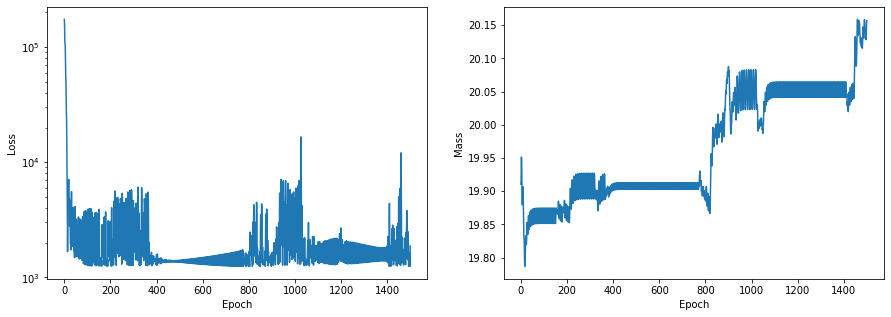

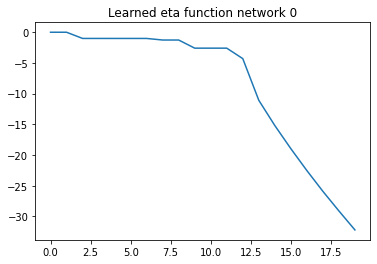

100%|██████████| 1500/1500 [00:16<00:00, 90.72it/s]


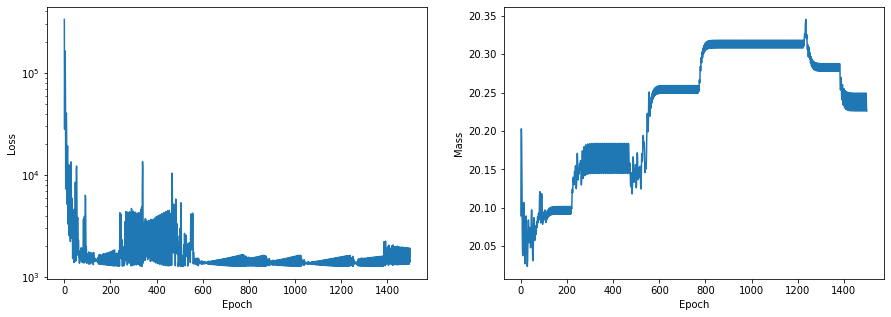

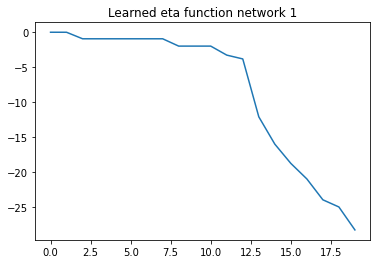

100%|██████████| 1500/1500 [00:15<00:00, 95.40it/s]


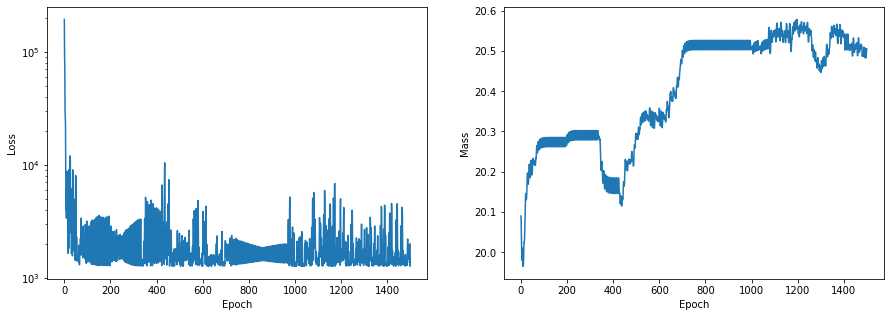

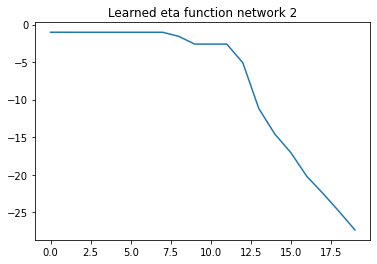

100%|██████████| 1500/1500 [00:15<00:00, 95.48it/s]


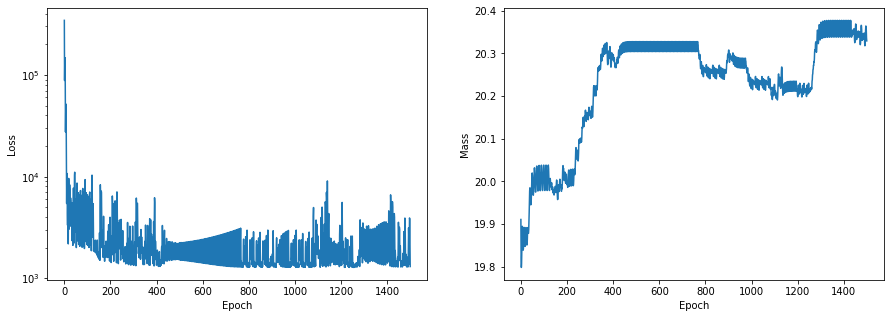

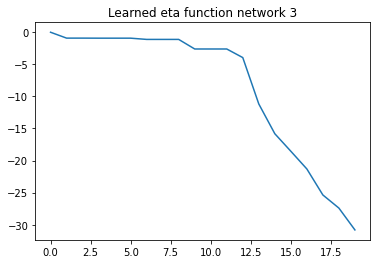

100%|██████████| 1500/1500 [00:15<00:00, 97.80it/s]


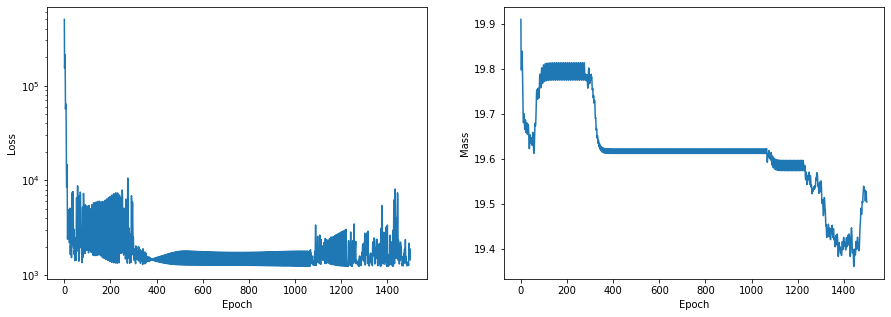

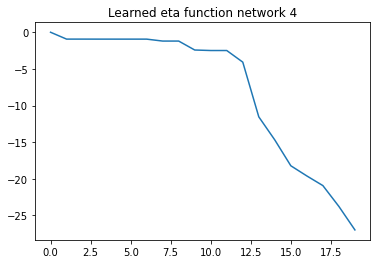

100%|██████████| 1500/1500 [00:15<00:00, 96.10it/s]


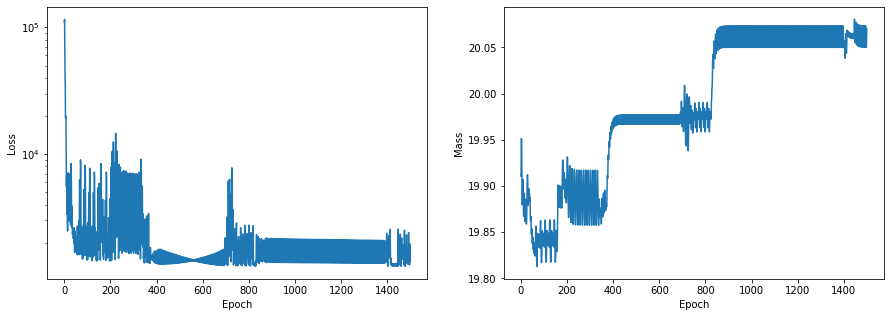

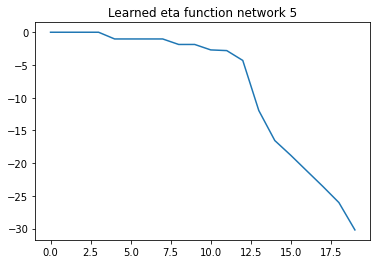

100%|██████████| 1500/1500 [00:15<00:00, 97.40it/s]


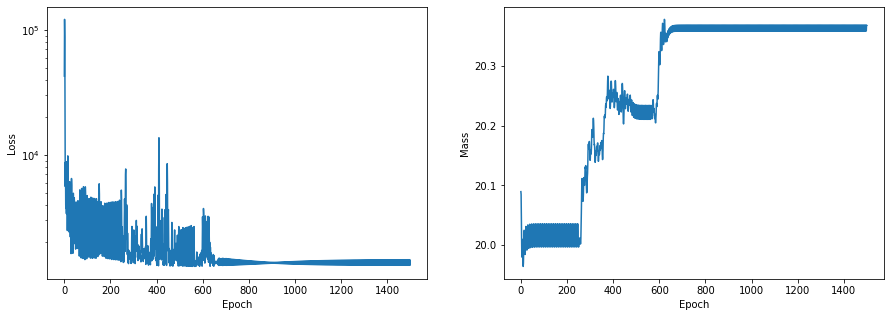

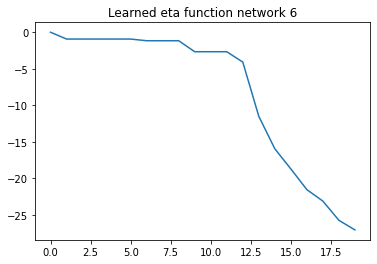

100%|██████████| 1500/1500 [00:15<00:00, 95.67it/s]


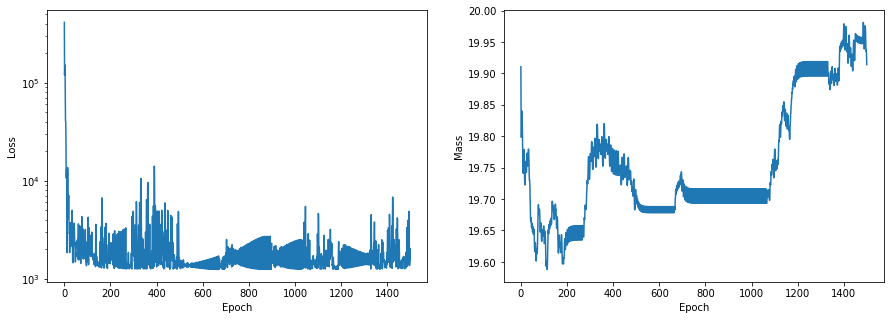

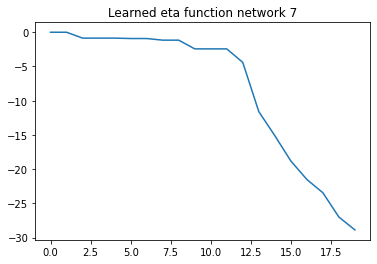

100%|██████████| 1500/1500 [00:15<00:00, 97.64it/s]


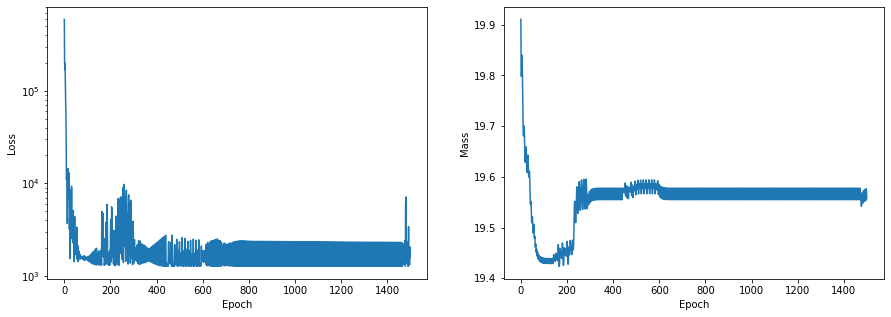

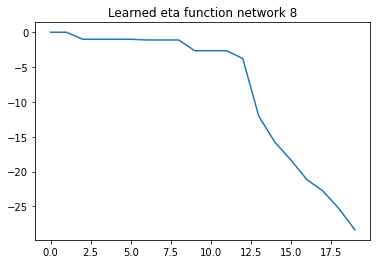

100%|██████████| 1500/1500 [00:15<00:00, 94.56it/s]


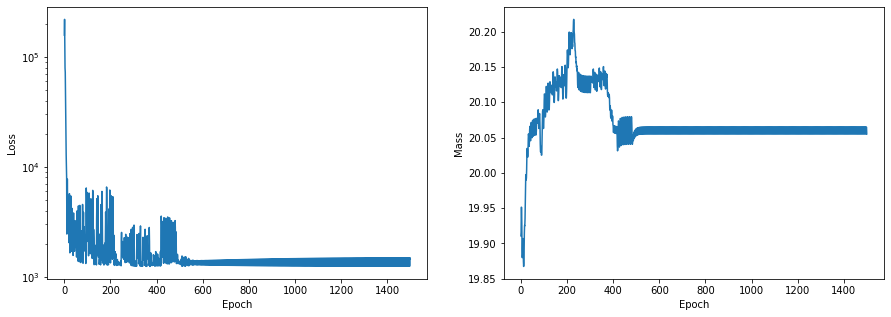

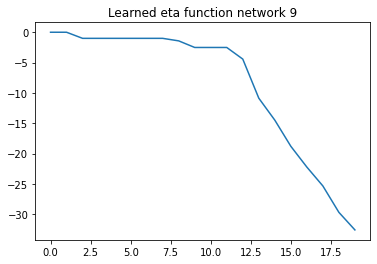

In [6]:
num_to_ensemble = 10
num_steps = 20

learned_params = torch.zeros((num_to_ensemble,num_steps)) # store the results here
learned_masses = []

for i in range(num_to_ensemble):
    
    loc_params, loc_mass = run_one_network(num_steps=num_steps, num_epochs = 1500)
    learned_params[i] = loc_params
    learned_masses.append(loc_mass)
    
    plt.figure()
    plt.plot(convert_params_to_fit_to_halo_id(loc_params).detach().cpu().numpy())
    plt.title(f"Learned eta function network {i}")
    plt.show()


Convert the learned parameters into eta

In [7]:
tien_halo_params = [220.0,232,544,0.4e9]

all_vmins = []
all_etas = []
all_eta_shm = []

for i in range(num_to_ensemble):

    loc_vmins, loc_etas, loc_eta_shm = plot_eta(learned_masses[i],convert_params_to_fit_to_halo_id(learned_params[i]),plot_mb=True,
                                    device=learned_params[i].device,save=False,cross_section=1e-37,
                                    halo_params=tien_halo_params,norm=1e-15,show_plot=False)
    
    all_vmins.append(loc_vmins)
    all_etas.append(loc_etas)
    all_eta_shm.append(loc_eta_shm)


/global/u1/r/rmastand/halo-independent-analysis/haloidp_analysis.py:207: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  etas =  torch.sum(step_heights_tiled * heaviside,axis=1).T


One thing that is a little tricky is that the vMin cutoff depends on the mass, so the arrays from different classifier runs are of different shapes. The best thing that I can think of to do is to plot all the results above the *maximum* vMin .

In [8]:
# get the maximum vMin
vMin_cutoff = np.max([all_vmins[i][0] for i in range(num_to_ensemble)])
# and the size of the arrays we should have
size_eta_arrays = np.min([all_vmins[i].shape[0] for i in range(num_to_ensemble)])

learned_etas = np.zeros((num_to_ensemble,size_eta_arrays)) 

for i in range(num_to_ensemble):
    loc_indices_to_take = all_vmins[i] >= vMin_cutoff
    learned_etas[i] = all_etas[i][loc_indices_to_take]
               
plotting_eta_shm = all_eta_shm[-1][loc_indices_to_take]
plotting_vmin = all_vmins[-1][loc_indices_to_take]



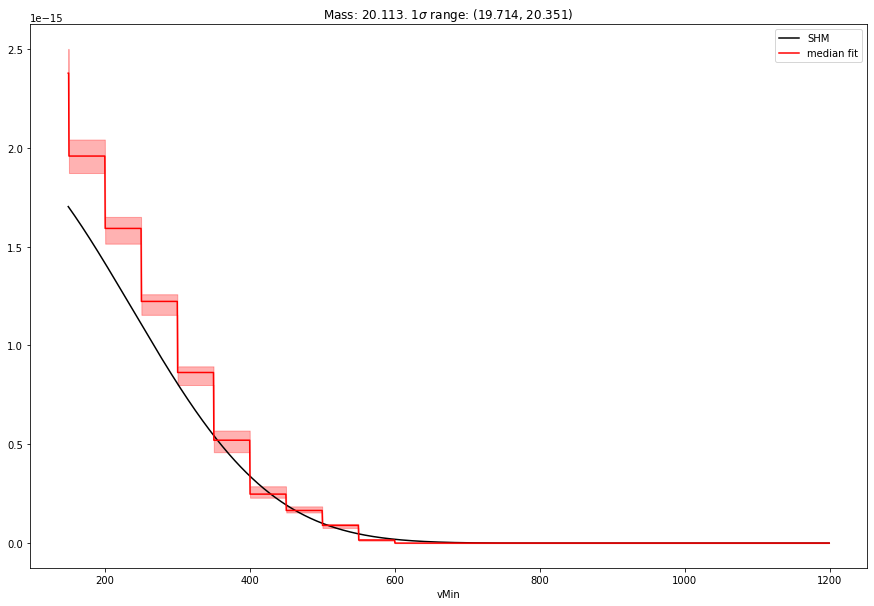

In [10]:
# get 1-sigma perentiles for mass, eta

mass_median = np.percentile(learned_masses, 50)
mass_lower = np.percentile(learned_masses, 16)
mass_upper = np.percentile(learned_masses, 84)

eta_median = np.percentile(learned_etas, 50, axis = 0)
eta_lower = np.percentile(learned_etas, 16, axis = 0)
eta_upper = np.percentile(learned_etas, 84, axis = 0)


plt.figure(figsize = (15, 10))
plt.plot(plotting_vmin, plotting_eta_shm, color = "k", label = "SHM")
plt.plot(plotting_vmin, eta_median, color = "red", label = "median fit" )
plt.fill_between(plotting_vmin, eta_lower, eta_upper, alpha = 0.3, color = "red")
plt.xlabel("vMin")
plt.legend()

plt.title(f"Mass: {round(mass_median, 3)}. 1$\sigma$ range: ({round(mass_lower, 3)}, {round(mass_upper, 3)})")
plt.show()
